# Baseline Model

In [1]:
using Pkg
Pkg.activate("/kuacc/users/ckorkmaz16/HiSD.jl/")

  Activating environment at `~/HiSD.jl/Project.toml`


## Load submodules

In [138]:
include("data.jl")
using .Data
include("transformations.jl")
using .Transformations
include("utils.jl")
using .Utils

In [22]:
using Images, Interpolations
using Images.FileIO
using Statistics
using Dates
using TensorBoardLogger, Logging, Random

In [14]:
using FileIO
using CUDA
using Knet

## Config

In [15]:
DATA_ROOT = "/kuacc/users/ckorkmaz16/HiSD_out"
CONFIG_FILE = "/kuacc/users/ckorkmaz16/HiSD.jl/configs/celeba-hq.yaml"

config = Utils.load_config(CONFIG_FILE)
println("Loaded config")

Loaded config


## Dataset / Minibatching Test

In [139]:
datasets = Utils.get_train_datasets(config, DATA_ROOT)
println("Loaded $(sum(length.(datasets))) datasets")

Loaded 7 datasets


In [157]:
(x,y),i = iterate(datasets[1][1], 0)
size(x), size(y), i, typeof(x), typeof(y)

((128, 128, 3, 8), (2, 8), 8, KnetArray{Float32, 4}, Knet.KnetArrays.KnetMatrix{Float32})

Re-obtain image from minibatch

size(xs) = (1, 3, 128, 128)


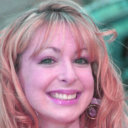

In [158]:
xs = x[:,:,:,1:1]
xs = permutedims(xs, [4, 3, 1, 2])
@show size(xs)
image = reshape(xs, size(xs)[2:end]...)
image = convert(Array, image)    
image = image .* 0.5 .+ 0.5
image = image .|> N0f8 |> colorview(RGB)
image

## Directories about training logs

In [20]:
curr_dt = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
OUTPUT_PATH = "/kuacc/users/ckorkmaz16/HiSD_out/baseline/$curr_dt"
output_directory, image_directory, checkpoint_directory, logs_directory = Utils.prepare_sub_folder(OUTPUT_PATH)
cp(CONFIG_FILE, joinpath(output_directory, "config.yaml"))
train_writer=TBLogger(joinpath(logs_directory, "run"))

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/baseline/2021-11-04_18-33-55/outputs
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/baseline/2021-11-04_18-33-55/outputs/images
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/baseline/2021-11-04_18-33-55/outputs/checkpoints
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/baseline/2021-11-04_18-33-55/logs


TBLogger:
	- Log level     : Info
	- Current step  : 0
	- Output        : /scratch/users/ckorkmaz16/HiSD_out/baseline/2021-11-04_18-33-55/logs/run
	- open files    : 1


In [21]:
total_iterations = config["total_iterations"]

200000

## Identity Baseline Model

In [74]:
module Baseline

struct BaselineModel; end

function encode(b::BaselineModel, x)
    x
end

function decode(b::BaselineModel, e)
    e
end

function extract(b::BaselineModel, x, i)
    x
end

function map(b::BaselineModel, z, i, j)
    z
end

function translate(b::BaselineModel, e, s, i)
    e
end

end

using .Baseline

## Inference and Testing

In [164]:
function inference(model, x, steps, transform, noise_dim)
    c = Baseline.encode(model, x)
    c_trg = c
    for step in steps
        if step["type"] == "latent-guided"
            z = convert(Knet.atype(), randn(1, noise_dim))
            s_trg = Baseline.map(model, z, step["tag"], step["attribute"])
        elseif step["type"] == "reference-guided"
            reference_idx = rand(1:length(step["reference"]))
            img = Data.load_test_image(step["reference"][reference_idx], transform, Knet.atype())
            s_trg = Baseline.extract(model, img, step["tag"])
        end
        c_trg = Baseline.translate(model, c_trg, s_trg, step["tag"])
    end
    x_trg = Baseline.decode(model, c_trg)
    x_trg
end

function test(model, config, steps, input_path, output_path)
    transform = Transformations.Compose(
        Transformations.to_tensor,
        Transformations.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    )
    if isfile(input_path)
        images = [input_path]
    else
        images = [joinpath(input_path, filename) for filename in readdir(input_path)]
    end
    for filename in images
        image = Data.load_test_image(filename, transform, Knet.atype())
        mapped = inference(model, image, steps, transform, config["noise_dim"])
        Data.save_test_image(joinpath(output_path, "$(basename(filename))_output.jpg"), mapped)
    end
end

test (generic function with 1 method)

# Latent-Guided Realism and Disentanglement

- FID from StarGANv2 like the original implementation [https://github.com/clovaai/stargan-v2](https://github.com/clovaai/stargan-v2) with the correct environment is required for obtaining the FIDs
- I did not create a seperate FID implementation, since any issues could create different results, the results depend on the specific implementation of the FID and specific pretrained checkpoint of InceptionV3 network

In [80]:
LATENT_REALISM_DIR = joinpath(DATA_ROOT, "outputs", "baseline", "latent_realism")
LATENT_DISENTANGLEMENT_DIR = joinpath(DATA_ROOT, "outputs", "baseline", "latent_disentanglement")

"/kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement"

### Latent-Guided Realism

Generate 5 images with added bangs to images in test set without bangs, save into 5 different folders, and calculate average FID to images in the test set with bangs.

In [81]:
DATASET_PATH = joinpath(DATA_ROOT, "datasets_test")
WITHOUT_BANGS = joinpath(DATASET_PATH, "Bangs_without.txt")
WITH_BANGS = joinpath(DATASET_PATH, "Bangs_with.txt")
WITHOUT_BANGS_OUT = joinpath(LATENT_REALISM_DIR, "without_bangs")
WITH_BANGS_OUT = joinpath(LATENT_REALISM_DIR, "with_bangs")

function copy_images(path, to_dir)
    lines = readlines(path)
    lines = (rstrip(line) |> split for line in lines)
    filenames = [line[1] for line in lines]
    Utils.create_dir!(to_dir)
    for filename in filenames
        cp(filename, joinpath(to_dir, basename(filename)))
    end
end

copy_images(WITHOUT_BANGS, WITHOUT_BANGS_OUT)
copy_images(WITH_BANGS, WITH_BANGS_OUT)

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_realism/without_bangs
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_realism/with_bangs


In [82]:
TEST_IN_PATH = joinpath(LATENT_REALISM_DIR, "without_bangs")
for i in 1:5
    test_out_path =  joinpath(LATENT_REALISM_DIR, "out_$(i)")
    Utils.create_dir!(test_out_path)
    steps = [Dict("type" => "latent-guided", "tag" => 0, "attribute" => 0)]
    test(Baseline.BaselineModel(), config, steps, TEST_IN_PATH, test_out_path)
end

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_realism/out_1
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_realism/out_2
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_realism/out_3
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_realism/out_4
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_realism/out_5


## Latent-Guided Disentanglement

Generate 5 images with added bangs to images in test set (without bangs and young and male), save into 5 different folders, and calculate average FID to images in the test set (young and male).

In [160]:
WITHOUT_BANGS_YM_OUT = joinpath(LATENT_DISENTANGLEMENT_DIR, "without_bangs")
WITH_BANGS_YM_OUT = joinpath(LATENT_DISENTANGLEMENT_DIR, "with_bangs")

function copy_images_young_male(path, to_dir)
    lines = readlines(path)
    lines = (rstrip(line) |> split for line in lines)
    parsed = [(line[1],parse(Int, line[2]),parse(Int, line[3])) for line in lines]
    Utils.create_dir!(to_dir)
    for (filename, gender, age) in parsed
        if gender == 1 && age == 1
            cp(filename, joinpath(to_dir, basename(filename)))
        end
    end
end

copy_images_young_male(WITHOUT_BANGS, WITHOUT_BANGS_YM_OUT)
copy_images_young_male(WITH_BANGS, WITH_BANGS_YM_OUT)

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement/without_bangs
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement/with_bangs


In [163]:
TEST_IN_PATH = joinpath(LATENT_DISENTANGLEMENT_DIR, "without_bangs")
for i in 1:5
    test_out_path =  joinpath(LATENT_DISENTANGLEMENT_DIR, "out_$(i)")
    Utils.create_dir!(test_out_path)
    steps = [Dict("type" => "latent-guided", "tag" => 0, "attribute" => 0)]
    test(Baseline.BaselineModel(), config, steps, TEST_IN_PATH, test_out_path)
end

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement/out_1
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement/out_2
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement/out_3
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement/out_4
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/latent_disentanglement/out_5


# Reference-Guided Realism and Disentanglement

In [165]:
REFERENCE_REALISM_DIR = joinpath(DATA_ROOT, "outputs", "baseline", "reference_realism")
REFERENCE_DISENTANGLEMENT_DIR = joinpath(DATA_ROOT, "outputs", "baseline", "reference_disentanglement")

"/kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement"

In [168]:
DATASET_TRAIN_PATH = joinpath(DATA_ROOT, "datasets", "Bangs_with.txt")
DATASET_TEST_PATH = joinpath(DATA_ROOT, "datasets_test", "Bangs_with.txt")
DATASET_PATHS = [DATASET_TRAIN_PATH, DATASET_TEST_PATH]
references_with_bangs = []
for dataset in DATASET_PATHS
    lines = readlines(dataset)
    lines = (rstrip(line) |> split for line in lines)
    filenames = [line[1] for line in lines]
    for filename in filenames
        push!(references_with_bangs, filename)
    end
end

## Reference-Guided Realism

In [166]:
DATASET_PATH = joinpath(DATA_ROOT, "datasets_test")
WITHOUT_BANGS = joinpath(DATASET_PATH, "Bangs_without.txt")
WITH_BANGS = joinpath(DATASET_PATH, "Bangs_with.txt")
WITHOUT_BANGS_OUT = joinpath(REFERENCE_REALISM_DIR, "without_bangs")
WITH_BANGS_OUT = joinpath(REFERENCE_REALISM_DIR, "with_bangs")

function copy_images(path, to_dir)
    lines = readlines(path)
    lines = (rstrip(line) |> split for line in lines)
    filenames = [line[1] for line in lines]
    Utils.create_dir!(to_dir)
    for filename in filenames
        cp(filename, joinpath(to_dir, basename(filename)))
    end
end

copy_images(WITHOUT_BANGS, WITHOUT_BANGS_OUT)
copy_images(WITH_BANGS, WITH_BANGS_OUT)

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_realism/without_bangs
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_realism/with_bangs


In [170]:
TEST_IN_PATH = joinpath(REFERENCE_REALISM_DIR, "without_bangs")
for i in 1:5
    test_out_path =  joinpath(REFERENCE_REALISM_DIR, "out_$(i)")
    Utils.create_dir!(test_out_path)
    steps = [Dict("type" => "reference-guided", "tag" => 0, "reference" => references_with_bangs)]
    test(Baseline.BaselineModel(), config, steps, TEST_IN_PATH, test_out_path)
end

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_realism/out_1
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_realism/out_2
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_realism/out_3
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_realism/out_4
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_realism/out_5


## Reference-Guided Realism

In [171]:
WITHOUT_BANGS_YM_OUT = joinpath(REFERENCE_DISENTANGLEMENT_DIR, "without_bangs")
WITH_BANGS_YM_OUT = joinpath(REFERENCE_DISENTANGLEMENT_DIR, "with_bangs")

function copy_images_young_male(path, to_dir)
    lines = readlines(path)
    lines = (rstrip(line) |> split for line in lines)
    parsed = [(line[1],parse(Int, line[2]),parse(Int, line[3])) for line in lines]
    Utils.create_dir!(to_dir)
    for (filename, gender, age) in parsed
        if gender == 1 && age == 1
            cp(filename, joinpath(to_dir, basename(filename)))
        end
    end
end

copy_images_young_male(WITHOUT_BANGS, WITHOUT_BANGS_YM_OUT)
copy_images_young_male(WITH_BANGS, WITH_BANGS_YM_OUT)

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement/without_bangs
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement/with_bangs


In [172]:
TEST_IN_PATH = joinpath(REFERENCE_DISENTANGLEMENT_DIR, "without_bangs")
for i in 1:5
    test_out_path =  joinpath(REFERENCE_DISENTANGLEMENT_DIR, "out_$(i)")
    Utils.create_dir!(test_out_path)
    steps = [Dict("type" => "reference-guided", "tag" => 0, "reference" => references_with_bangs)]
    test(Baseline.BaselineModel(), config, steps, TEST_IN_PATH, test_out_path)
end

Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement/out_1
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement/out_2
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement/out_3
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement/out_4
Creating directory: /kuacc/users/ckorkmaz16/HiSD_out/outputs/baseline/reference_disentanglement/out_5
